In [1]:
#To hide warnings export PYTHONWARNINGS="ignore"
#Imports{

import os
from os.path import dirname
from os.path import join
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Cha


import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import pickle
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.misc import imread
from scipy.misc import imresize
from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cluster import MiniBatchKMeans

import keras
import tensorflow as tf
from tensorflow.keras import backend as K
#}

Using TensorFlow backend.


In [2]:
# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())

# confirm Keras sees the GPU (for TensorFlow 1.X + Keras)
from keras import backend
assert len(backend.tensorflow_backend._get_available_gpus()) > 0

# confirm PyTorch sees the GPU
from torch import cuda
assert cuda.is_available()
assert cuda.device_count() > 0
print(cuda.get_device_name(cuda.current_device()))


W0224 17:26:28.984570 140131347175168 deprecation_wrapper.py:119] From /home/abhijit/.conda/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0224 17:26:28.985262 140131347175168 deprecation_wrapper.py:119] From /home/abhijit/.conda/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0224 17:26:28.985985 140131347175168 deprecation_wrapper.py:119] From /home/abhijit/.conda/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0224 17:26:28.990662 140131347175168 deprecation_wrapper.py:119] From /home/abhijit/.conda/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. P

GeForce GTX 1080


Model architecture
<img src="../../data/misc/vgg16.png">

In [3]:
#Code snippet needed to read activation values from each layer of the pre-trained artificial neural networks
def get_activations(model, layer, X_batch):
    #keras.backend.function(inputs, outputs, updates=None)
    get_activations = tf.keras.backend.function([model.layers[0].input, tf.keras.backend.learning_phase()], [model.layers[layer].output,])
    #The learning phase flag is a bool tensor (0 = test, 1 = train)
    activations = get_activations([X_batch,0])
    return activations

In [4]:
#Function to pre-process the input image to ensure uniform size and color
def preprocess_image_batch(image_paths, img_size=None, crop_size=None, color_mode='rgb', out=None):
    """
    Consistent preprocessing of images batches
    :param image_paths: iterable: images to process
    :param crop_size: tuple: crop images if specified
    :param img_size: tuple: resize images if specified
    :param color_mode: Use rgb or change to bgr mode based on type of model you want to use
    :param out: append output to this iterable if specified
    """
    img_list = []

    for im_path in image_paths:
        img = imread(im_path, mode='RGB')
        #print im_path
        #print img.shape
        if img_size:
            img = imresize(img, img_size)

        img = img.astype('float32')
        # We normalize the colors (in RGB space) with the empirical means on the training set
        img[:, :, 0] -= 123.68
        img[:, :, 1] -= 116.779
        img[:, :, 2] -= 103.939
        # We permute the colors to get them in the BGR order
        if color_mode == 'bgr':
            img[:, :, [0, 1, 2]] = img[:, :, [2, 1, 0]]
        img = img.transpose((2, 0, 1))

        if crop_size:
            img = img[:, (img_size[0] - crop_size[0]) // 2:(img_size[0] + crop_size[0]) // 2
            , (img_size[1] - crop_size[1]) // 2:(img_size[1] + crop_size[1]) // 2]

        img_list.append(img)

    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        print(im_path)
        raise ValueError('when img_size and crop_size are None, images'
                ' in image_paths must have the same shapes.')

    if out is not None and hasattr(out, 'append'):
        out.append(img_batch)
    else:
        return img_batch

In [5]:
#Function to predict the top 5 accuracy
def top5accuracy(true, predicted):
    assert len(true) == len(predicted)
    result = []
    flag  = 0
    for i in range(len(true)):
        flag  = 0
        temp = true[i]
        for j in predicted[i]:
            if j == temp:
                flag = 1
                break
        if flag == 1:
            result.append(1)
        else:
            result.append(0)
    counter = 0.
    for i in result:
        if i == 1:
            counter += 1.
    error = 1.0 - counter/float(len(result))
    #print len(np.where(np.asarray(result) == 1)[0])
    return len(np.where(np.asarray(result) == 1)[0]), error

In [6]:
#Load the details of all the 1000 classes and the function to conver the synset id to words{
meta_clsloc_file = '../../data/meta_clsloc.mat'
synsets = loadmat(meta_clsloc_file)['synsets'][0]
synsets_imagenet_sorted = sorted([(int(s[0]), str(s[1][0])) for s in synsets[:1000]],key=lambda v: v[1])
corr = {}
for j in range(1000):
    corr[synsets_imagenet_sorted[j][0]] = j

corr_inv = {}
for j in range(1, 1001):
    corr_inv[corr[j]] = j

def id_to_words(id_):
    return synsets[corr_inv[id_] - 1][2][0]

def pprint_output(out, n_max_synsets=10):
    wids = []
    best_ids = out.argsort()[::-1][:10]
    for u in best_ids:
        wids.append(str(synsets[corr_inv[u] - 1][1][0]))
    #print('%.2f' % round(100 * out[u], 2) + ' : ' + id_to_words(u)+' '+ str(synsets[corr_inv[u] - 1][1][0]))
    return wids

In [7]:
#Code snippet to load the ground truth labels to measure the performance{
truth = {}
with open('../../data/ILSVRC2014_clsloc_validation_ground_truth.txt') as f:
    line_num = 1
    for line in f.readlines():
        ind_ = int(line)
        temp  = None
        for i in synsets_imagenet_sorted:
            if i[0] == ind_:
                temp = i
        #print ind_,temp
        if temp != None:
            truth[line_num] = temp
        else:
            print('##########', ind_)
            pass
        line_num += 1
#}

In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow.keras.utils as keras_utils
from tensorflow.keras.layers import Lambda

from  keras.applications import imagenet_utils
from  keras.applications.imagenet_utils import decode_predictions
from  keras_applications.imagenet_utils import _obtain_input_shape

preprocess_input = imagenet_utils.preprocess_input

WEIGHTS_PATH = ('https://github.com/fchollet/deep-learning-models/'
                'releases/download/v0.1/'
                'vgg16_weights_tf_dim_ordering_tf_kernels.h5')
WEIGHTS_PATH_NO_TOP = ('https://github.com/fchollet/deep-learning-models/'
                       'releases/download/v0.1/'
                       'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')


def VGG16(include_top=True,
          weights='imagenet',
          input_tensor=None,
          input_shape=None,
          pooling=None,
          classes=1000,
          lambda_mask=None,
          **kwargs):
    
    backend= tf.keras.backend
    layers = tf.keras.layers
    models = tf.keras.models
    keras_utils = tf.keras.utils
    
    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(img_input)
    
    if lambda_mask is not None:
        block_1_conv_1_mask  = np.reshape(lambda_mask[0:3211264], (64, 224, 224))
    else:
        block_1_conv_1_mask = np.ones(shape=((64, 224, 224)))
    
    block_1_conv_1_mask  = backend.variable(block_1_conv_1_mask)
    block_1_conv_1_lambda = Lambda(lambda x: x * block_1_conv_1_mask)(x)
    
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(block_1_conv_1_lambda)
    
    if lambda_mask is not None:
        block_1_conv_2_mask  = np.reshape(lambda_mask[3211264:6422528], (64, 224, 224))
    else:
        block_1_conv_2_mask = np.ones(shape=((64, 224, 224)))
    
    block_1_conv_2_mask  = backend.variable(block_1_conv_2_mask)
    block_1_conv_2_lambda = Lambda(lambda x: x * block_1_conv_2_mask)(x)
    
    
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(block_1_conv_2_lambda)

    # Block 2
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    
    if lambda_mask is not None:
        block_2_conv_1_mask  = np.reshape(lambda_mask[6422528:8028160], (128, 112, 112))
    else:
        block_2_conv_1_mask = np.ones(shape=((128, 112, 112)))
    
    block_2_conv_1_mask  = backend.variable(block_2_conv_1_mask)
    block_2_conv_1_lambda = Lambda(lambda x: x * block_2_conv_1_mask)(x)
    
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(block_2_conv_1_lambda)
    
    
    if lambda_mask is not None:
        block_2_conv_2_mask  = np.reshape(lambda_mask[8028160:9633792], (128, 112, 112))
    else:
        block_2_conv_2_mask = np.ones(shape=((128, 112, 112)))
    
    block_2_conv_2_mask  = backend.variable(block_2_conv_2_mask)
    block_2_conv_2_lambda = Lambda(lambda x: x * block_2_conv_2_mask)(x)
    
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(block_2_conv_2_lambda)

    # Block 3
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    
    if lambda_mask is not None:
        block_3_conv_1_mask  = np.reshape(lambda_mask[9633792:10436608], (256, 56, 56))
    else:
        block_3_conv_1_mask = np.ones(shape=((256, 56, 56)))
    
    block_3_conv_1_mask  = backend.variable(block_3_conv_1_mask)
    block_3_conv_1_lambda = Lambda(lambda x: x * block_3_conv_1_mask)(x)
    
    
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2')(block_3_conv_1_lambda)
    
    if lambda_mask is not None:
        block_3_conv_2_mask  = np.reshape(lambda_mask[10436608:11239424], (256, 56, 56))
    else:
        block_3_conv_2_mask = np.ones(shape=((256, 56, 56)))
    
    block_3_conv_2_mask  = backend.variable(block_3_conv_2_mask)
    block_3_conv_2_lambda = Lambda(lambda x: x * block_3_conv_2_mask)(x)
    
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3')( block_3_conv_2_lambda)
    
    if lambda_mask is not None:
        block_3_conv_3_mask  = np.reshape(lambda_mask[11239424:12042240], (256, 56, 56))
    else:
        block_3_conv_3_mask = np.ones(shape=((256, 56, 56)))
    
    block_3_conv_3_mask  = backend.variable(block_3_conv_3_mask)
    block_3_conv_3_lambda = Lambda(lambda x: x * block_3_conv_3_mask)(x)
    
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(block_3_conv_3_lambda)

    # Block 4
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1')(x)
    
    if lambda_mask is not None:
        block_4_conv_1_mask  = np.reshape(lambda_mask[12042240:12443648], (512, 28, 28))
    else:
        block_4_conv_1_mask = np.ones(shape=((512, 28, 28)))
    
    block_4_conv_1_mask  = backend.variable(block_4_conv_1_mask)
    block_4_conv_1_lambda = Lambda(lambda x: x * block_4_conv_1_mask)(x)
    
    
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2')(block_4_conv_1_lambda)
    
    if lambda_mask is not None:
        block_4_conv_2_mask  = np.reshape(lambda_mask[12443648:12845056], (512, 28, 28))
    else:
        block_4_conv_2_mask = np.ones(shape=((512, 28, 28)))
    
    block_4_conv_2_mask  = backend.variable(block_4_conv_2_mask)
    block_4_conv_2_lambda = Lambda(lambda x: x * block_4_conv_2_mask)(x)
    
    
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3')(block_4_conv_2_lambda)
    
    
    if lambda_mask is not None:
        block_4_conv_3_mask  = np.reshape(lambda_mask[12845056:13246464], (512, 28, 28))
    else:
        block_4_conv_3_mask = np.ones(shape=((512, 28, 28)))
    
    block_4_conv_3_mask  = backend.variable(block_4_conv_3_mask)
    block_4_conv_3_lambda = Lambda(lambda x: x * block_4_conv_3_mask)(x)
    
    
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')( block_4_conv_3_lambda)

    # Block 5
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv1')(x)
    
    if lambda_mask is not None:
        block_5_conv_1_mask  = np.reshape(lambda_mask[13246464:13346816], (512, 14, 14))
    else:
        block_5_conv_1_mask = np.ones(shape=((512, 14, 14)))
    
    block_5_conv_1_mask  = backend.variable(block_5_conv_1_mask)
    block_5_conv_1_lambda = Lambda(lambda x: x * block_5_conv_1_mask)(x)
    
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv2')(block_5_conv_1_lambda)
    
    if lambda_mask is not None:
        block_5_conv_2_mask  = np.reshape(lambda_mask[13346816:13447168], (512, 14, 14))
    else:
        block_5_conv_2_mask = np.ones(shape=((512, 14, 14)))
    
    block_5_conv_2_mask  = backend.variable(block_5_conv_2_mask)
    block_5_conv_2_lambda = Lambda(lambda x: x * block_5_conv_2_mask)(x)
    
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv3')(block_5_conv_2_lambda)
    
    if lambda_mask is not None:
        block_5_conv_3_mask  = np.reshape(lambda_mask[13447168:13547520], (512, 14, 14))
    else:
        block_5_conv_3_mask = np.ones(shape=((512, 14, 14)))
    
    block_5_conv_3_mask  = backend.variable(block_5_conv_3_mask)
    block_5_conv_3_lambda = Lambda(lambda x: x * block_5_conv_3_mask)(x)
    
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')( block_5_conv_3_lambda)

    if include_top:
        # Classification block
        x = layers.Flatten(name='flatten')(x)
        x = layers.Dense(4096, activation='relu', name='fc1')(x)
        
        if lambda_mask is not None:
            block_fc1_mask  = np.reshape(lambda_mask[13547520:13551616], (4096,))
        else:
            block_fc1_mask = np.ones(shape=((4096,)))
        block_fc1_mask  = backend.variable(block_fc1_mask)
        block_fc1_lambda = Lambda(lambda x: x * block_fc1_mask)(x)
    
        x = layers.Dense(4096, activation='relu', name='fc2')(block_fc1_lambda)
        
        if lambda_mask is not None:
            block_fc2_mask  = np.reshape(lambda_mask[13551616:13555712], (4096,))
        else:
            block_fc2_mask = np.ones(shape=((4096,)))
        block_fc2_mask  = backend.variable(block_fc2_mask)
        block_fc2_lambda = Lambda(lambda x: x * block_fc2_mask)(x)
        
        x = layers.Dense(classes, activation='softmax', name='predictions')(block_fc2_lambda)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = models.Model(inputs, x, name='vgg16')

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            weights_path = keras_utils.get_file(
                'vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                file_hash='64373286793e3c8b2b4e3219cbf3544b')
        else:
            weights_path = keras_utils.get_file(
                'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                file_hash='6d6bbae143d832006294945121d1f1fc')
        model.load_weights(weights_path)
        if backend.backend() == 'theano':
            keras_utils.convert_all_kernels_in_model(model)
    elif weights is not None:
        model.load_weights(weights)

    return model

In [9]:
model_name = 'VGG16'
model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
model.summary()

W0224 17:26:32.603277 140131347175168 deprecation.py:506] From /home/abhijit/.conda/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 224, 224)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 224, 224)      1792      
_________________________________________________________________
lambda (Lambda)              (None, 64, 224, 224)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 224, 224)      36928     
_________________________________________________________________
lambda_1 (Lambda)            (None, 64, 224, 224)      0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 112, 112)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 112, 112)     73856 

In [10]:
import gc
K.image_data_format()
tf.keras.backend.clear_session()
gc.collect()
del model

In [ ]:
%%time
#Test Cell 1

data_path = '../../data/pkl/'
classes = ['animate','inanimate']
fold = 1

with open(data_path+classes[0]+'_train_'+model_name+'.pkl','rb') as f:
        X_fold = pickle.load(f)
with open(data_path+classes[1]+'_train_'+model_name+'.pkl','rb') as f:
        y_fold = pickle.load(f)
    
X = np.column_stack((X_fold,y_fold))
X = np.float32(X)


kmeans = MiniBatchKMeans(n_clusters=67783, #200x reduction in points
                         max_iter=10).fit(X)

pred_kmeans = kmeans.predict(X)

X_new = kmeans.cluster_centers_

with open('../../data/pkl/kmeans_first_train_'+model_name+'.pkl', 'wb') as handle:
    pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)


In [11]:
#%%time
#Version 1 - Reading pkl files from step 0 and clustering it{
data_path = '../../data/pkl/'
classes = ['animate','inanimate']


result= {}

k = 4 #Total Number of folds
fold = 1

for i in range(k):
    
    print('Perfoming Fold: ', fold)
    clf_result = {}
    
    if os.path.exists('../../data/pkl/kmeans_first_'+str(fold)+'_'+model_name+'.pkl'):
        with open('../../data/pkl/kmeans_first_'+str(fold)+'_'+model_name+'.pkl',"rb") as f:
            X_new,pred_kmeans,kmeans = pickle.load(f)
    else:   
        with open(data_path+classes[0]+'_fold_'+str(fold)+'_train_'+model_name+'.pkl','rb') as f:
            X_fold = pickle.load(f)
        with open(data_path+classes[1]+'_fold_'+str(fold)+'_train_'+model_name+'.pkl','rb') as f:
            y_fold = pickle.load(f)

        X = np.column_stack((X_fold,y_fold))
        kmeans = MiniBatchKMeans(n_clusters=67783,
                                 max_iter=10).fit(X)
        #print kmeans.cluster_centers_
        pred_kmeans = kmeans.predict(X)
        X_new = kmeans.cluster_centers_

        with open('../../data/pkl/kmeans_first_'+str(fold)+'_'+model_name+'.pkl', 'wb') as handle:
            pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)

    #DO CLUSTERING AND GET CLUSTERS
    
    from sklearn.cluster import KMeans
    from sklearn.cluster import SpectralClustering
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.cluster import Birch
    from sklearn.mixture import GaussianMixture
    
    method ='GMM'
    print(method)
    for j in range(1,51,1):
 
        clf_result[j] = {}

        clf = KMeans(n_clusters=j)    
        #clf =  AgglomerativeClustering(n_clusters=j, linkage='ward')
        #clf = Birch(branching_factor=50, n_clusters=j, threshold=0.5,compute_labels=True)
        clf = GaussianMixture(n_components=j, covariance_type='full')
        y_pred = clf.fit_predict(X_new)
        #print clf.cluster_centers_

        for label in set(y_pred):
            print('Cluster: ',j,'Label: ', label)
            
            #Lesioning and measuring performance
            pred = y_pred.copy()
            loc = np.where(pred==label)
            loc_temp = kmeans.predict(X_new[loc[0]])
            loc_new =[]
            for entry in set(loc_temp):
                temp = np.where(pred_kmeans==entry)[0]
                loc_new.extend(temp)

            lambda_mask = np.ones(shape=((13555712,)))
            lambda_mask[loc_new] = 0.

            #plt.scatter(X[:,0],X[:,1], c=y_pred) 
            #Change Model
            model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000,lambda_mask=lambda_mask)

            flag = 0
            dprime = 0.
            for p in classes:
                im_valid_test = []
                image_list_valid = '../../data/pkl/'+p+'_image_list_valid_fold_'+str(fold)+'.txt'
                with open(image_list_valid,'r') as f:
                    for line in f.readlines():
                        im_valid_test.append(line.strip('\n'))
                im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
                out = model.predict(im_temp,batch_size=64)

                true_valid_wids = []
                for i in im_valid_test:
                        temp1 = i.split('/')[4]
                        temp = temp1.split('.')[0].split('_')[2]
                        true_valid_wids.append(truth[int(temp)][1])

                predicted_valid_wids = []
                for i in range(len(im_valid_test)):
                    #print im_list[i], pprint_output(out[i]), true_wids[i]
                    predicted_valid_wids.append(pprint_output(out[i]))

                count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

                print(str(p)+' '+str(fold)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error))
                
                if flag == 0:
                    dprime = error
                    flag = 1
                else:
                    dprime -= error
                    
            tf.keras.backend.clear_session()
            gc.collect()
            del model
            clf_result[j][label] = dprime
    
    with open('../../data/pkl/'+str(method)+'_50_scree_fold_'+str(fold)+'_'+model_name+'.pkl', 'wb') as handle:
        pickle.dump(clf_result, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    result[fold] = clf_result
    fold += 1
#}

Perfoming Fold:  1
GMM
Cluster:  1 Label:  0
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  2 Label:  0
animate 1 0 39 1.0
inanimate 1 5 39 0.8717948717948718
Cluster:  2 Label:  1
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  3 Label:  0
animate 1 0 39 1.0
inanimate 1 2 39 0.9487179487179487
Cluster:  3 Label:  1
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  3 Label:  2
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  4 Label:  0
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  4 Label:  1
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  4 Label:  2
animate 1 8 39 0.7948717948717949
inanimate 1 17 39 0.5641025641025641
Cluster:  4 Label:  3
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  5 Label:  0
animate 1 0 39 1.0
inanimate 1 4 39 0.8974358974358975
Cluster:  5 Label:  1
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  5 Label:  2
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.128205128205

animate 1 12 39 0.6923076923076923
inanimate 1 35 39 0.10256410256410253
Cluster:  14 Label:  5
animate 1 7 39 0.8205128205128205
inanimate 1 35 39 0.10256410256410253
Cluster:  14 Label:  6
animate 1 34 39 0.1282051282051282
inanimate 1 19 39 0.5128205128205128
Cluster:  14 Label:  7
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  14 Label:  8
animate 1 21 39 0.46153846153846156
inanimate 1 23 39 0.41025641025641024
Cluster:  14 Label:  9
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  14 Label:  10
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  14 Label:  11
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  14 Label:  12
animate 1 2 39 0.9487179487179487
inanimate 1 0 39 1.0
Cluster:  14 Label:  13
animate 1 35 39 0.10256410256410253
inanimate 1 30 39 0.23076923076923073
Cluster:  15 Label:  0
animate 1 18 39 0.5384615384615384
inanimate 1 21 39 0.46153846153846156
Cluster:  15 L

animate 1 26 39 0.33333333333333337
inanimate 1 34 39 0.1282051282051282
Cluster:  19 Label:  13
animate 1 34 39 0.1282051282051282
inanimate 1 30 39 0.23076923076923073
Cluster:  19 Label:  14
animate 1 24 39 0.3846153846153846
inanimate 1 34 39 0.1282051282051282
Cluster:  19 Label:  15
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  19 Label:  16
animate 1 14 39 0.641025641025641
inanimate 1 35 39 0.10256410256410253
Cluster:  19 Label:  17
animate 1 30 39 0.23076923076923073
inanimate 1 21 39 0.46153846153846156
Cluster:  19 Label:  18
animate 1 15 39 0.6153846153846154
inanimate 1 34 39 0.1282051282051282
Cluster:  20 Label:  0
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  20 Label:  1
animate 1 22 39 0.4358974358974359
inanimate 1 24 39 0.3846153846153846
Cluster:  20 Label:  2
animate 1 35 39 0.10256410256410253
inanimate 1 35 39 0.10256410256410253
Cluster:  20 Label:  3
animate 1 7 39 0.8205128205128205
inanimate 1 0 39 1.0
Cluster:  20 L

inanimate 1 35 39 0.10256410256410253
Cluster:  23 Label:  17
animate 1 3 39 0.9230769230769231
inanimate 1 8 39 0.7948717948717949
Cluster:  23 Label:  18
animate 1 27 39 0.3076923076923077
inanimate 1 33 39 0.15384615384615385
Cluster:  23 Label:  19
animate 1 32 39 0.17948717948717952
inanimate 1 33 39 0.15384615384615385
Cluster:  23 Label:  20
animate 1 24 39 0.3846153846153846
inanimate 1 34 39 0.1282051282051282
Cluster:  23 Label:  21
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  23 Label:  22
animate 1 26 39 0.33333333333333337
inanimate 1 34 39 0.1282051282051282
Cluster:  24 Label:  0
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  24 Label:  1
animate 1 31 39 0.20512820512820518
inanimate 1 36 39 0.07692307692307687
Cluster:  24 Label:  2
animate 1 31 39 0.20512820512820518
inanimate 1 34 39 0.1282051282051282
Cluster:  24 Label:  3
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  24 Label:  4
animate

inanimate 1 35 39 0.10256410256410253
Cluster:  27 Label:  5
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  27 Label:  6
animate 1 30 39 0.23076923076923073
inanimate 1 34 39 0.1282051282051282
Cluster:  27 Label:  7
animate 1 35 39 0.10256410256410253
inanimate 1 35 39 0.10256410256410253
Cluster:  27 Label:  8
animate 1 30 39 0.23076923076923073
inanimate 1 34 39 0.1282051282051282
Cluster:  27 Label:  9
animate 1 35 39 0.10256410256410253
inanimate 1 32 39 0.17948717948717952
Cluster:  27 Label:  10
animate 1 30 39 0.23076923076923073
inanimate 1 34 39 0.1282051282051282
Cluster:  27 Label:  11
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  27 Label:  12
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  27 Label:  13
animate 1 36 39 0.07692307692307687
inanimate 1 29 39 0.2564102564102564
Cluster:  27 Label:  14
animate 1 35 39 0.10256410256410253
inanimate 1 32 39 0.17948717948717952
Cluster:  27 Label:  15
ani

inanimate 1 35 39 0.10256410256410253
Cluster:  30 Label:  7
animate 1 31 39 0.20512820512820518
inanimate 1 34 39 0.1282051282051282
Cluster:  30 Label:  8
animate 1 29 39 0.2564102564102564
inanimate 1 35 39 0.10256410256410253
Cluster:  30 Label:  9
animate 1 33 39 0.15384615384615385
inanimate 1 35 39 0.10256410256410253
Cluster:  30 Label:  10
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  30 Label:  11
animate 1 33 39 0.15384615384615385
inanimate 1 32 39 0.17948717948717952
Cluster:  30 Label:  12
animate 1 30 39 0.23076923076923073
inanimate 1 37 39 0.05128205128205132
Cluster:  30 Label:  13
animate 1 35 39 0.10256410256410253
inanimate 1 31 39 0.20512820512820518
Cluster:  30 Label:  14
animate 1 27 39 0.3076923076923077
inanimate 1 34 39 0.1282051282051282
Cluster:  30 Label:  15
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  30 Label:  16
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282

animate 1 36 39 0.07692307692307687
inanimate 1 32 39 0.17948717948717952
Cluster:  33 Label:  0
animate 1 10 39 0.7435897435897436
inanimate 1 34 39 0.1282051282051282
Cluster:  33 Label:  1
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  33 Label:  2
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  33 Label:  3
animate 1 31 39 0.20512820512820518
inanimate 1 33 39 0.15384615384615385
Cluster:  33 Label:  4
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  33 Label:  5
animate 1 35 39 0.10256410256410253
inanimate 1 35 39 0.10256410256410253
Cluster:  33 Label:  6
animate 1 32 39 0.17948717948717952
inanimate 1 34 39 0.1282051282051282
Cluster:  33 Label:  7
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  33 Label:  8
animate 1 35 39 0.10256410256410253
inanimate 1 35 39 0.10256410256410253
Cluster:  33 Label:  9
animate 1 33 39 0.15384615384615385
inanimate 1 35 39 0.10256410256410

animate 1 35 39 0.10256410256410253
inanimate 1 35 39 0.10256410256410253
Cluster:  35 Label:  19
animate 1 35 39 0.10256410256410253
inanimate 1 35 39 0.10256410256410253
Cluster:  35 Label:  20
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  35 Label:  21
animate 1 33 39 0.15384615384615385
inanimate 1 35 39 0.10256410256410253
Cluster:  35 Label:  22
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  35 Label:  23
animate 1 29 39 0.2564102564102564
inanimate 1 35 39 0.10256410256410253
Cluster:  35 Label:  24
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  35 Label:  25
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  35 Label:  26
animate 1 35 39 0.10256410256410253
inanimate 1 36 39 0.07692307692307687
Cluster:  35 Label:  27
animate 1 32 39 0.17948717948717952
inanimate 1 34 39 0.1282051282051282
Cluster:  35 Label:  28
animate 1 34 39 0.12820512

inanimate 1 34 39 0.1282051282051282
Cluster:  37 Label:  33
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  37 Label:  34
animate 1 31 39 0.20512820512820518
inanimate 1 33 39 0.15384615384615385
Cluster:  37 Label:  35
animate 1 35 39 0.10256410256410253
inanimate 1 32 39 0.17948717948717952
Cluster:  37 Label:  36
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  38 Label:  0
animate 1 35 39 0.10256410256410253
inanimate 1 35 39 0.10256410256410253
Cluster:  38 Label:  1
animate 1 34 39 0.1282051282051282
inanimate 1 14 39 0.641025641025641
Cluster:  38 Label:  2
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  38 Label:  3
animate 1 31 39 0.20512820512820518
inanimate 1 34 39 0.1282051282051282
Cluster:  38 Label:  4
animate 1 35 39 0.10256410256410253
inanimate 1 36 39 0.07692307692307687
Cluster:  38 Label:  5
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.12820512820512

animate 1 30 39 0.23076923076923073
inanimate 1 34 39 0.1282051282051282
Cluster:  40 Label:  5
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  40 Label:  6
animate 1 35 39 0.10256410256410253
inanimate 1 35 39 0.10256410256410253
Cluster:  40 Label:  7
animate 1 33 39 0.15384615384615385
inanimate 1 35 39 0.10256410256410253
Cluster:  40 Label:  8
animate 1 35 39 0.10256410256410253
inanimate 1 36 39 0.07692307692307687
Cluster:  40 Label:  9
animate 1 35 39 0.10256410256410253
inanimate 1 35 39 0.10256410256410253
Cluster:  40 Label:  10
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  40 Label:  11
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  40 Label:  12
animate 1 35 39 0.10256410256410253
inanimate 1 35 39 0.10256410256410253
Cluster:  40 Label:  13
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  40 Label:  14
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051

inanimate 1 35 39 0.10256410256410253
Cluster:  42 Label:  9
animate 1 35 39 0.10256410256410253
inanimate 1 36 39 0.07692307692307687
Cluster:  42 Label:  10
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  42 Label:  11
animate 1 36 39 0.07692307692307687
inanimate 1 36 39 0.07692307692307687
Cluster:  42 Label:  12
animate 1 35 39 0.10256410256410253
inanimate 1 35 39 0.10256410256410253
Cluster:  42 Label:  13
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  42 Label:  14
animate 1 31 39 0.20512820512820518
inanimate 1 33 39 0.15384615384615385
Cluster:  42 Label:  15
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  42 Label:  16
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  42 Label:  17
animate 1 35 39 0.10256410256410253
inanimate 1 35 39 0.10256410256410253
Cluster:  42 Label:  18
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.12820

animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  44 Label:  10
animate 1 32 39 0.17948717948717952
inanimate 1 34 39 0.1282051282051282
Cluster:  44 Label:  11
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  44 Label:  12
animate 1 31 39 0.20512820512820518
inanimate 1 34 39 0.1282051282051282
Cluster:  44 Label:  13
animate 1 35 39 0.10256410256410253
inanimate 1 36 39 0.07692307692307687
Cluster:  44 Label:  14
animate 1 33 39 0.15384615384615385
inanimate 1 34 39 0.1282051282051282
Cluster:  44 Label:  15
animate 1 35 39 0.10256410256410253
inanimate 1 35 39 0.10256410256410253
Cluster:  44 Label:  16
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  44 Label:  17
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  44 Label:  18
animate 1 31 39 0.20512820512820518
inanimate 1 36 39 0.07692307692307687
Cluster:  44 Label:  19
animate 1 35 39 0.10256410256410253
inanimate 1 35 39 0.102

inanimate 1 34 39 0.1282051282051282
Cluster:  46 Label:  6
animate 1 31 39 0.20512820512820518
inanimate 1 13 39 0.6666666666666667
Cluster:  46 Label:  7
animate 1 35 39 0.10256410256410253
inanimate 1 35 39 0.10256410256410253
Cluster:  46 Label:  8
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  46 Label:  9
animate 1 35 39 0.10256410256410253
inanimate 1 35 39 0.10256410256410253
Cluster:  46 Label:  10
animate 1 36 39 0.07692307692307687
inanimate 1 32 39 0.17948717948717952
Cluster:  46 Label:  11
animate 1 35 39 0.10256410256410253
inanimate 1 35 39 0.10256410256410253
Cluster:  46 Label:  12
animate 1 31 39 0.20512820512820518
inanimate 1 35 39 0.10256410256410253
Cluster:  46 Label:  13
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  46 Label:  14
animate 1 32 39 0.17948717948717952
inanimate 1 34 39 0.1282051282051282
Cluster:  46 Label:  15
animate 1 35 39 0.10256410256410253
inanimate 1 36 39 0.07692307

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  47 Label:  46
animate 1 34 39 0.1282051282051282
inanimate 1 14 39 0.641025641025641
Cluster:  48 Label:  0
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  48 Label:  1
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  48 Label:  2
animate 1 33 39 0.15384615384615385
inanimate 1 37 39 0.05128205128205132
Cluster:  48 Label:  3
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  48 Label:  4
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  48 Label:  5
animate 1 33 39 0.15384615384615385
inanimate 1 14 39 0.641025641025641
Cluster:  48 Label:  6
animate 1 35 39 0.10256410256410253
inanimate 1 35 39 0.10256410256410253
Cluster:  48 Label:  7
animate 1 35 39 0.10256410256410253
inanimate 1 36 39 0.07692307692307687
Cluster:  48 Label:  8
animate 1 35 39 0.10256410256410253
inan

animate 1 35 39 0.10256410256410253
inanimate 1 35 39 0.10256410256410253
Cluster:  49 Label:  36
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  49 Label:  37
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  49 Label:  38
animate 1 33 39 0.15384615384615385
inanimate 1 35 39 0.10256410256410253
Cluster:  49 Label:  39
animate 1 31 39 0.20512820512820518
inanimate 1 34 39 0.1282051282051282
Cluster:  49 Label:  40
animate 1 35 39 0.10256410256410253
inanimate 1 36 39 0.07692307692307687
Cluster:  49 Label:  41
animate 1 34 39 0.1282051282051282
inanimate 1 35 39 0.10256410256410253
Cluster:  49 Label:  42
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  49 Label:  43
animate 1 35 39 0.10256410256410253
inanimate 1 36 39 0.07692307692307687
Cluster:  49 Label:  44
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  49 Label:  45
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282

animate 2 0 39 1.0
inanimate 2 0 39 1.0
Cluster:  7 Label:  6
animate 2 8 39 0.7948717948717949
inanimate 2 0 39 1.0
Cluster:  8 Label:  0
animate 2 0 39 1.0
inanimate 2 0 39 1.0
Cluster:  8 Label:  1
animate 2 0 39 1.0
inanimate 2 30 39 0.23076923076923073
Cluster:  8 Label:  2
animate 2 30 39 0.23076923076923073
inanimate 2 22 39 0.4358974358974359
Cluster:  8 Label:  3
animate 2 8 39 0.7948717948717949
inanimate 2 0 39 1.0
Cluster:  8 Label:  4
animate 2 3 39 0.9230769230769231
inanimate 2 31 39 0.20512820512820518
Cluster:  8 Label:  5
animate 2 35 39 0.10256410256410253
inanimate 2 32 39 0.17948717948717952
Cluster:  8 Label:  6
animate 2 33 39 0.15384615384615385
inanimate 2 32 39 0.17948717948717952
Cluster:  8 Label:  7
animate 2 0 39 1.0
inanimate 2 2 39 0.9487179487179487
Cluster:  9 Label:  0
animate 2 23 39 0.41025641025641024
inanimate 2 0 39 1.0
Cluster:  9 Label:  1
animate 2 0 39 1.0
inanimate 2 1 39 0.9743589743589743
Cluster:  9 Label:  2
animate 2 18 39 0.53846153846

animate 2 35 39 0.10256410256410253
inanimate 2 32 39 0.17948717948717952
Cluster:  15 Label:  14
animate 2 34 39 0.1282051282051282
inanimate 2 30 39 0.23076923076923073
Cluster:  16 Label:  0
animate 2 27 39 0.3076923076923077
inanimate 2 30 39 0.23076923076923073
Cluster:  16 Label:  1
animate 2 0 39 1.0
inanimate 2 0 39 1.0
Cluster:  16 Label:  2
animate 2 34 39 0.1282051282051282
inanimate 2 31 39 0.20512820512820518
Cluster:  16 Label:  3
animate 2 35 39 0.10256410256410253
inanimate 2 32 39 0.17948717948717952
Cluster:  16 Label:  4
animate 2 30 39 0.23076923076923073
inanimate 2 34 39 0.1282051282051282
Cluster:  16 Label:  5
animate 2 14 39 0.641025641025641
inanimate 2 33 39 0.15384615384615385
Cluster:  16 Label:  6
animate 2 34 39 0.1282051282051282
inanimate 2 26 39 0.33333333333333337
Cluster:  16 Label:  7
animate 2 35 39 0.10256410256410253
inanimate 2 16 39 0.5897435897435898
Cluster:  16 Label:  8
animate 2 22 39 0.4358974358974359
inanimate 2 32 39 0.1794871794871795

animate 2 34 39 0.1282051282051282
inanimate 2 32 39 0.17948717948717952
Cluster:  20 Label:  16
animate 2 34 39 0.1282051282051282
inanimate 2 35 39 0.10256410256410253
Cluster:  20 Label:  17
animate 2 35 39 0.10256410256410253
inanimate 2 32 39 0.17948717948717952
Cluster:  20 Label:  18
animate 2 7 39 0.8205128205128205
inanimate 2 33 39 0.15384615384615385
Cluster:  20 Label:  19
animate 2 21 39 0.46153846153846156
inanimate 2 0 39 1.0
Cluster:  21 Label:  0
animate 2 36 39 0.07692307692307687
inanimate 2 25 39 0.3589743589743589
Cluster:  21 Label:  1
animate 2 31 39 0.20512820512820518
inanimate 2 33 39 0.15384615384615385
Cluster:  21 Label:  2
animate 2 35 39 0.10256410256410253
inanimate 2 32 39 0.17948717948717952
Cluster:  21 Label:  3
animate 2 0 39 1.0
inanimate 2 0 39 1.0
Cluster:  21 Label:  4
animate 2 34 39 0.1282051282051282
inanimate 2 31 39 0.20512820512820518
Cluster:  21 Label:  5
animate 2 34 39 0.1282051282051282
inanimate 2 32 39 0.17948717948717952
Cluster:  

inanimate 2 33 39 0.15384615384615385
Cluster:  24 Label:  16
animate 2 35 39 0.10256410256410253
inanimate 2 32 39 0.17948717948717952
Cluster:  24 Label:  17
animate 2 34 39 0.1282051282051282
inanimate 2 34 39 0.1282051282051282
Cluster:  24 Label:  18
animate 2 35 39 0.10256410256410253
inanimate 2 32 39 0.17948717948717952
Cluster:  24 Label:  19
animate 2 32 39 0.17948717948717952
inanimate 2 33 39 0.15384615384615385
Cluster:  24 Label:  20
animate 2 31 39 0.20512820512820518
inanimate 2 32 39 0.17948717948717952
Cluster:  24 Label:  21
animate 2 29 39 0.2564102564102564
inanimate 2 33 39 0.15384615384615385
Cluster:  24 Label:  22
animate 2 34 39 0.1282051282051282
inanimate 2 30 39 0.23076923076923073
Cluster:  24 Label:  23
animate 2 7 39 0.8205128205128205
inanimate 2 7 39 0.8205128205128205
Cluster:  25 Label:  0
animate 2 0 39 1.0
inanimate 2 0 39 1.0
Cluster:  25 Label:  1
animate 2 34 39 0.1282051282051282
inanimate 2 31 39 0.20512820512820518
Cluster:  25 Label:  2
anim

animate 2 33 39 0.15384615384615385
inanimate 2 33 39 0.15384615384615385
Cluster:  28 Label:  0
animate 2 33 39 0.15384615384615385
inanimate 2 33 39 0.15384615384615385
Cluster:  28 Label:  1
animate 2 2 39 0.9487179487179487
inanimate 2 34 39 0.1282051282051282
Cluster:  28 Label:  2
animate 2 34 39 0.1282051282051282
inanimate 2 34 39 0.1282051282051282
Cluster:  28 Label:  3
animate 2 35 39 0.10256410256410253
inanimate 2 31 39 0.20512820512820518
Cluster:  28 Label:  4
animate 2 33 39 0.15384615384615385
inanimate 2 29 39 0.2564102564102564
Cluster:  28 Label:  5
animate 2 34 39 0.1282051282051282
inanimate 2 32 39 0.17948717948717952
Cluster:  28 Label:  6
animate 2 30 39 0.23076923076923073
inanimate 2 2 39 0.9487179487179487
Cluster:  28 Label:  7
animate 2 36 39 0.07692307692307687
inanimate 2 32 39 0.17948717948717952
Cluster:  28 Label:  8
animate 2 34 39 0.1282051282051282
inanimate 2 32 39 0.17948717948717952
Cluster:  28 Label:  9
animate 2 33 39 0.15384615384615385
inan

animate 2 35 39 0.10256410256410253
inanimate 2 31 39 0.20512820512820518
Cluster:  30 Label:  29
animate 2 33 39 0.15384615384615385
inanimate 2 34 39 0.1282051282051282
Cluster:  31 Label:  0
animate 2 0 39 1.0
inanimate 2 0 39 1.0
Cluster:  31 Label:  1
animate 2 33 39 0.15384615384615385
inanimate 2 34 39 0.1282051282051282
Cluster:  31 Label:  2
animate 2 35 39 0.10256410256410253
inanimate 2 27 39 0.3076923076923077
Cluster:  31 Label:  3
animate 2 33 39 0.15384615384615385
inanimate 2 32 39 0.17948717948717952
Cluster:  31 Label:  4
animate 2 35 39 0.10256410256410253
inanimate 2 31 39 0.20512820512820518
Cluster:  31 Label:  5
animate 2 36 39 0.07692307692307687
inanimate 2 32 39 0.17948717948717952
Cluster:  31 Label:  6
animate 2 5 39 0.8717948717948718
inanimate 2 34 39 0.1282051282051282
Cluster:  31 Label:  7
animate 2 35 39 0.10256410256410253
inanimate 2 31 39 0.20512820512820518
Cluster:  31 Label:  8
animate 2 35 39 0.10256410256410253
inanimate 2 31 39 0.2051282051282

animate 2 30 39 0.23076923076923073
inanimate 2 33 39 0.15384615384615385
Cluster:  33 Label:  22
animate 2 34 39 0.1282051282051282
inanimate 2 34 39 0.1282051282051282
Cluster:  33 Label:  23
animate 2 33 39 0.15384615384615385
inanimate 2 32 39 0.17948717948717952
Cluster:  33 Label:  24
animate 2 36 39 0.07692307692307687
inanimate 2 32 39 0.17948717948717952
Cluster:  33 Label:  25
animate 2 31 39 0.20512820512820518
inanimate 2 32 39 0.17948717948717952
Cluster:  33 Label:  26
animate 2 34 39 0.1282051282051282
inanimate 2 33 39 0.15384615384615385
Cluster:  33 Label:  27
animate 2 35 39 0.10256410256410253
inanimate 2 31 39 0.20512820512820518
Cluster:  33 Label:  28
animate 2 34 39 0.1282051282051282
inanimate 2 33 39 0.15384615384615385
Cluster:  33 Label:  29
animate 2 33 39 0.15384615384615385
inanimate 2 33 39 0.15384615384615385
Cluster:  33 Label:  30
animate 2 35 39 0.10256410256410253
inanimate 2 31 39 0.20512820512820518
Cluster:  33 Label:  31
animate 2 36 39 0.076923

inanimate 2 32 39 0.17948717948717952
Cluster:  36 Label:  5
animate 2 33 39 0.15384615384615385
inanimate 2 31 39 0.20512820512820518
Cluster:  36 Label:  6
animate 2 0 39 1.0
inanimate 2 0 39 1.0
Cluster:  36 Label:  7
animate 2 35 39 0.10256410256410253
inanimate 2 30 39 0.23076923076923073
Cluster:  36 Label:  8
animate 2 34 39 0.1282051282051282
inanimate 2 33 39 0.15384615384615385
Cluster:  36 Label:  9
animate 2 34 39 0.1282051282051282
inanimate 2 34 39 0.1282051282051282
Cluster:  36 Label:  10
animate 2 34 39 0.1282051282051282
inanimate 2 33 39 0.15384615384615385
Cluster:  36 Label:  11
animate 2 36 39 0.07692307692307687
inanimate 2 32 39 0.17948717948717952
Cluster:  36 Label:  12
animate 2 35 39 0.10256410256410253
inanimate 2 31 39 0.20512820512820518
Cluster:  36 Label:  13
animate 2 35 39 0.10256410256410253
inanimate 2 27 39 0.3076923076923077
Cluster:  36 Label:  14
animate 2 34 39 0.1282051282051282
inanimate 2 34 39 0.1282051282051282
Cluster:  36 Label:  15
anim

animate 2 35 39 0.10256410256410253
inanimate 2 32 39 0.17948717948717952
Cluster:  38 Label:  18
animate 2 34 39 0.1282051282051282
inanimate 2 33 39 0.15384615384615385
Cluster:  38 Label:  19
animate 2 35 39 0.10256410256410253
inanimate 2 29 39 0.2564102564102564
Cluster:  38 Label:  20
animate 2 32 39 0.17948717948717952
inanimate 2 30 39 0.23076923076923073
Cluster:  38 Label:  21
animate 2 34 39 0.1282051282051282
inanimate 2 33 39 0.15384615384615385
Cluster:  38 Label:  22
animate 2 35 39 0.10256410256410253
inanimate 2 29 39 0.2564102564102564
Cluster:  38 Label:  23
animate 2 0 39 1.0
inanimate 2 0 39 1.0
Cluster:  38 Label:  24
animate 2 35 39 0.10256410256410253
inanimate 2 31 39 0.20512820512820518
Cluster:  38 Label:  25
animate 2 34 39 0.1282051282051282
inanimate 2 32 39 0.17948717948717952
Cluster:  38 Label:  26
animate 2 34 39 0.1282051282051282
inanimate 2 32 39 0.17948717948717952
Cluster:  38 Label:  27
animate 2 34 39 0.1282051282051282
inanimate 2 34 39 0.12820

inanimate 2 32 39 0.17948717948717952
Cluster:  40 Label:  26
animate 2 35 39 0.10256410256410253
inanimate 2 31 39 0.20512820512820518
Cluster:  40 Label:  27
animate 2 35 39 0.10256410256410253
inanimate 2 32 39 0.17948717948717952
Cluster:  40 Label:  28
animate 2 35 39 0.10256410256410253
inanimate 2 32 39 0.17948717948717952
Cluster:  40 Label:  29
animate 2 35 39 0.10256410256410253
inanimate 2 31 39 0.20512820512820518
Cluster:  40 Label:  30
animate 2 34 39 0.1282051282051282
inanimate 2 28 39 0.28205128205128205
Cluster:  40 Label:  31
animate 2 33 39 0.15384615384615385
inanimate 2 32 39 0.17948717948717952
Cluster:  40 Label:  32
animate 2 34 39 0.1282051282051282
inanimate 2 34 39 0.1282051282051282
Cluster:  40 Label:  33
animate 2 32 39 0.17948717948717952
inanimate 2 33 39 0.15384615384615385
Cluster:  40 Label:  34
animate 2 34 39 0.1282051282051282
inanimate 2 33 39 0.15384615384615385
Cluster:  40 Label:  35
animate 2 34 39 0.1282051282051282
inanimate 2 34 39 0.12820

inanimate 2 32 39 0.17948717948717952
Cluster:  42 Label:  30
animate 2 35 39 0.10256410256410253
inanimate 2 31 39 0.20512820512820518
Cluster:  42 Label:  31
animate 2 35 39 0.10256410256410253
inanimate 2 31 39 0.20512820512820518
Cluster:  42 Label:  32
animate 2 31 39 0.20512820512820518
inanimate 2 34 39 0.1282051282051282
Cluster:  42 Label:  33
animate 2 34 39 0.1282051282051282
inanimate 2 33 39 0.15384615384615385
Cluster:  42 Label:  34
animate 2 34 39 0.1282051282051282
inanimate 2 34 39 0.1282051282051282
Cluster:  42 Label:  35
animate 2 35 39 0.10256410256410253
inanimate 2 32 39 0.17948717948717952
Cluster:  42 Label:  36
animate 2 35 39 0.10256410256410253
inanimate 2 32 39 0.17948717948717952
Cluster:  42 Label:  37
animate 2 35 39 0.10256410256410253
inanimate 2 31 39 0.20512820512820518
Cluster:  42 Label:  38
animate 2 33 39 0.15384615384615385
inanimate 2 32 39 0.17948717948717952
Cluster:  42 Label:  39
animate 2 34 39 0.1282051282051282
inanimate 2 32 39 0.17948

animate 2 35 39 0.10256410256410253
inanimate 2 31 39 0.20512820512820518
Cluster:  44 Label:  30
animate 2 35 39 0.10256410256410253
inanimate 2 31 39 0.20512820512820518
Cluster:  44 Label:  31
animate 2 35 39 0.10256410256410253
inanimate 2 30 39 0.23076923076923073
Cluster:  44 Label:  32
animate 2 34 39 0.1282051282051282
inanimate 2 33 39 0.15384615384615385
Cluster:  44 Label:  33
animate 2 34 39 0.1282051282051282
inanimate 2 33 39 0.15384615384615385
Cluster:  44 Label:  34
animate 2 0 39 1.0
inanimate 2 0 39 1.0
Cluster:  44 Label:  35
animate 2 36 39 0.07692307692307687
inanimate 2 32 39 0.17948717948717952
Cluster:  44 Label:  36
animate 2 35 39 0.10256410256410253
inanimate 2 33 39 0.15384615384615385
Cluster:  44 Label:  37
animate 2 12 39 0.6923076923076923
inanimate 2 35 39 0.10256410256410253
Cluster:  44 Label:  38
animate 2 35 39 0.10256410256410253
inanimate 2 32 39 0.17948717948717952
Cluster:  44 Label:  39
animate 2 35 39 0.10256410256410253
inanimate 2 32 39 0.1

animate 2 11 39 0.717948717948718
inanimate 2 35 39 0.10256410256410253
Cluster:  46 Label:  26
animate 2 35 39 0.10256410256410253
inanimate 2 33 39 0.15384615384615385
Cluster:  46 Label:  27
animate 2 33 39 0.15384615384615385
inanimate 2 32 39 0.17948717948717952
Cluster:  46 Label:  28
animate 2 34 39 0.1282051282051282
inanimate 2 33 39 0.15384615384615385
Cluster:  46 Label:  29
animate 2 35 39 0.10256410256410253
inanimate 2 31 39 0.20512820512820518
Cluster:  46 Label:  30
animate 2 35 39 0.10256410256410253
inanimate 2 28 39 0.28205128205128205
Cluster:  46 Label:  31
animate 2 35 39 0.10256410256410253
inanimate 2 31 39 0.20512820512820518
Cluster:  46 Label:  32
animate 2 35 39 0.10256410256410253
inanimate 2 29 39 0.2564102564102564
Cluster:  46 Label:  33
animate 2 31 39 0.20512820512820518
inanimate 2 34 39 0.1282051282051282
Cluster:  46 Label:  34
animate 2 35 39 0.10256410256410253
inanimate 2 32 39 0.17948717948717952
Cluster:  46 Label:  35
animate 2 0 39 1.0
inanim

animate 2 33 39 0.15384615384615385
inanimate 2 34 39 0.1282051282051282
Cluster:  48 Label:  18
animate 2 35 39 0.10256410256410253
inanimate 2 31 39 0.20512820512820518
Cluster:  48 Label:  19
animate 2 34 39 0.1282051282051282
inanimate 2 33 39 0.15384615384615385
Cluster:  48 Label:  20
animate 2 34 39 0.1282051282051282
inanimate 2 30 39 0.23076923076923073
Cluster:  48 Label:  21
animate 2 0 39 1.0
inanimate 2 0 39 1.0
Cluster:  48 Label:  22
animate 2 35 39 0.10256410256410253
inanimate 2 32 39 0.17948717948717952
Cluster:  48 Label:  23
animate 2 35 39 0.10256410256410253
inanimate 2 31 39 0.20512820512820518
Cluster:  48 Label:  24
animate 2 35 39 0.10256410256410253
inanimate 2 31 39 0.20512820512820518
Cluster:  48 Label:  25
animate 2 34 39 0.1282051282051282
inanimate 2 33 39 0.15384615384615385
Cluster:  48 Label:  26
animate 2 35 39 0.10256410256410253
inanimate 2 32 39 0.17948717948717952
Cluster:  48 Label:  27
animate 2 35 39 0.10256410256410253
inanimate 2 32 39 0.17

animate 2 35 39 0.10256410256410253
inanimate 2 32 39 0.17948717948717952
Cluster:  50 Label:  6
animate 2 36 39 0.07692307692307687
inanimate 2 32 39 0.17948717948717952
Cluster:  50 Label:  7
animate 2 34 39 0.1282051282051282
inanimate 2 34 39 0.1282051282051282
Cluster:  50 Label:  8
animate 2 35 39 0.10256410256410253
inanimate 2 31 39 0.20512820512820518
Cluster:  50 Label:  9
animate 2 34 39 0.1282051282051282
inanimate 2 33 39 0.15384615384615385
Cluster:  50 Label:  10
animate 2 34 39 0.1282051282051282
inanimate 2 32 39 0.17948717948717952
Cluster:  50 Label:  11
animate 2 35 39 0.10256410256410253
inanimate 2 30 39 0.23076923076923073
Cluster:  50 Label:  12
animate 2 34 39 0.1282051282051282
inanimate 2 32 39 0.17948717948717952
Cluster:  50 Label:  13
animate 2 33 39 0.15384615384615385
inanimate 2 32 39 0.17948717948717952
Cluster:  50 Label:  14
animate 2 35 39 0.10256410256410253
inanimate 2 32 39 0.17948717948717952
Cluster:  50 Label:  15
animate 2 34 39 0.12820512820

animate 3 37 39 0.05128205128205132
inanimate 3 36 39 0.07692307692307687
Cluster:  10 Label:  3
animate 3 0 39 1.0
inanimate 3 0 39 1.0
Cluster:  10 Label:  4
animate 3 18 39 0.5384615384615384
inanimate 3 0 39 1.0
Cluster:  10 Label:  5
animate 3 34 39 0.1282051282051282
inanimate 3 31 39 0.20512820512820518
Cluster:  10 Label:  6
animate 3 36 39 0.07692307692307687
inanimate 3 35 39 0.10256410256410253
Cluster:  10 Label:  7
animate 3 0 39 1.0
inanimate 3 2 39 0.9487179487179487
Cluster:  10 Label:  8
animate 3 27 39 0.3076923076923077
inanimate 3 7 39 0.8205128205128205
Cluster:  10 Label:  9
animate 3 1 39 0.9743589743589743
inanimate 3 26 39 0.33333333333333337
Cluster:  11 Label:  0
animate 3 0 39 1.0
inanimate 3 33 39 0.15384615384615385
Cluster:  11 Label:  1
animate 3 36 39 0.07692307692307687
inanimate 3 31 39 0.20512820512820518
Cluster:  11 Label:  2
animate 3 23 39 0.41025641025641024
inanimate 3 24 39 0.3846153846153846
Cluster:  11 Label:  3
animate 3 0 39 1.0
inanimate

animate 3 32 39 0.17948717948717952
inanimate 3 32 39 0.17948717948717952
Cluster:  17 Label:  2
animate 3 33 39 0.15384615384615385
inanimate 3 7 39 0.8205128205128205
Cluster:  17 Label:  3
animate 3 25 39 0.3589743589743589
inanimate 3 31 39 0.20512820512820518
Cluster:  17 Label:  4
animate 3 37 39 0.05128205128205132
inanimate 3 36 39 0.07692307692307687
Cluster:  17 Label:  5
animate 3 36 39 0.07692307692307687
inanimate 3 35 39 0.10256410256410253
Cluster:  17 Label:  6
animate 3 0 39 1.0
inanimate 3 0 39 1.0
Cluster:  17 Label:  7
animate 3 37 39 0.05128205128205132
inanimate 3 36 39 0.07692307692307687
Cluster:  17 Label:  8
animate 3 33 39 0.15384615384615385
inanimate 3 33 39 0.15384615384615385
Cluster:  17 Label:  9
animate 3 7 39 0.8205128205128205
inanimate 3 33 39 0.15384615384615385
Cluster:  17 Label:  10
animate 3 24 39 0.3846153846153846
inanimate 3 27 39 0.3076923076923077
Cluster:  17 Label:  11
animate 3 33 39 0.15384615384615385
inanimate 3 34 39 0.1282051282051

animate 3 29 39 0.2564102564102564
inanimate 3 26 39 0.33333333333333337
Cluster:  21 Label:  15
animate 3 36 39 0.07692307692307687
inanimate 3 18 39 0.5384615384615384
Cluster:  21 Label:  16
animate 3 28 39 0.28205128205128205
inanimate 3 32 39 0.17948717948717952
Cluster:  21 Label:  17
animate 3 31 39 0.20512820512820518
inanimate 3 34 39 0.1282051282051282
Cluster:  21 Label:  18
animate 3 32 39 0.17948717948717952
inanimate 3 35 39 0.10256410256410253
Cluster:  21 Label:  19
animate 3 34 39 0.1282051282051282
inanimate 3 34 39 0.1282051282051282
Cluster:  21 Label:  20
animate 3 20 39 0.4871794871794872
inanimate 3 35 39 0.10256410256410253
Cluster:  22 Label:  0
animate 3 34 39 0.1282051282051282
inanimate 3 34 39 0.1282051282051282
Cluster:  22 Label:  1
animate 3 32 39 0.17948717948717952
inanimate 3 28 39 0.28205128205128205
Cluster:  22 Label:  2
animate 3 4 39 0.8974358974358975
inanimate 3 15 39 0.6153846153846154
Cluster:  22 Label:  3
animate 3 33 39 0.15384615384615385

animate 3 34 39 0.1282051282051282
inanimate 3 35 39 0.10256410256410253
Cluster:  25 Label:  11
animate 3 0 39 1.0
inanimate 3 0 39 1.0
Cluster:  25 Label:  12
animate 3 36 39 0.07692307692307687
inanimate 3 24 39 0.3846153846153846
Cluster:  25 Label:  13
animate 3 34 39 0.1282051282051282
inanimate 3 33 39 0.15384615384615385
Cluster:  25 Label:  14
animate 3 37 39 0.05128205128205132
inanimate 3 35 39 0.10256410256410253
Cluster:  25 Label:  15
animate 3 36 39 0.07692307692307687
inanimate 3 35 39 0.10256410256410253
Cluster:  25 Label:  16
animate 3 25 39 0.3589743589743589
inanimate 3 35 39 0.10256410256410253
Cluster:  25 Label:  17
animate 3 32 39 0.17948717948717952
inanimate 3 4 39 0.8974358974358975
Cluster:  25 Label:  18
animate 3 33 39 0.15384615384615385
inanimate 3 34 39 0.1282051282051282
Cluster:  25 Label:  19
animate 3 37 39 0.05128205128205132
inanimate 3 31 39 0.20512820512820518
Cluster:  25 Label:  20
animate 3 36 39 0.07692307692307687
inanimate 3 31 39 0.20512

animate 3 37 39 0.05128205128205132
inanimate 3 31 39 0.20512820512820518
Cluster:  28 Label:  19
animate 3 36 39 0.07692307692307687
inanimate 3 34 39 0.1282051282051282
Cluster:  28 Label:  20
animate 3 36 39 0.07692307692307687
inanimate 3 26 39 0.33333333333333337
Cluster:  28 Label:  21
animate 3 35 39 0.10256410256410253
inanimate 3 35 39 0.10256410256410253
Cluster:  28 Label:  22
animate 3 34 39 0.1282051282051282
inanimate 3 5 39 0.8717948717948718
Cluster:  28 Label:  23
animate 3 36 39 0.07692307692307687
inanimate 3 35 39 0.10256410256410253
Cluster:  28 Label:  24
animate 3 0 39 1.0
inanimate 3 31 39 0.20512820512820518
Cluster:  28 Label:  25
animate 3 32 39 0.17948717948717952
inanimate 3 30 39 0.23076923076923073
Cluster:  28 Label:  26
animate 3 26 39 0.33333333333333337
inanimate 3 35 39 0.10256410256410253
Cluster:  28 Label:  27
animate 3 34 39 0.1282051282051282
inanimate 3 35 39 0.10256410256410253
Cluster:  29 Label:  0
animate 3 35 39 0.10256410256410253
inanima

inanimate 3 35 39 0.10256410256410253
Cluster:  31 Label:  17
animate 3 35 39 0.10256410256410253
inanimate 3 35 39 0.10256410256410253
Cluster:  31 Label:  18
animate 3 36 39 0.07692307692307687
inanimate 3 31 39 0.20512820512820518
Cluster:  31 Label:  19
animate 3 36 39 0.07692307692307687
inanimate 3 35 39 0.10256410256410253
Cluster:  31 Label:  20
animate 3 35 39 0.10256410256410253
inanimate 3 34 39 0.1282051282051282
Cluster:  31 Label:  21
animate 3 32 39 0.17948717948717952
inanimate 3 34 39 0.1282051282051282
Cluster:  31 Label:  22
animate 3 33 39 0.15384615384615385
inanimate 3 29 39 0.2564102564102564
Cluster:  31 Label:  23
animate 3 34 39 0.1282051282051282
inanimate 3 35 39 0.10256410256410253
Cluster:  31 Label:  24
animate 3 35 39 0.10256410256410253
inanimate 3 35 39 0.10256410256410253
Cluster:  31 Label:  25
animate 3 27 39 0.3076923076923077
inanimate 3 35 39 0.10256410256410253
Cluster:  31 Label:  26
animate 3 36 39 0.07692307692307687
inanimate 3 29 39 0.25641

animate 3 0 39 1.0
inanimate 3 0 39 1.0
Cluster:  34 Label:  7
animate 3 37 39 0.05128205128205132
inanimate 3 35 39 0.10256410256410253
Cluster:  34 Label:  8
animate 3 33 39 0.15384615384615385
inanimate 3 35 39 0.10256410256410253
Cluster:  34 Label:  9
animate 3 34 39 0.1282051282051282
inanimate 3 35 39 0.10256410256410253
Cluster:  34 Label:  10
animate 3 35 39 0.10256410256410253
inanimate 3 35 39 0.10256410256410253
Cluster:  34 Label:  11
animate 3 29 39 0.2564102564102564
inanimate 3 35 39 0.10256410256410253
Cluster:  34 Label:  12
animate 3 36 39 0.07692307692307687
inanimate 3 35 39 0.10256410256410253
Cluster:  34 Label:  13
animate 3 36 39 0.07692307692307687
inanimate 3 28 39 0.28205128205128205
Cluster:  34 Label:  14
animate 3 35 39 0.10256410256410253
inanimate 3 35 39 0.10256410256410253
Cluster:  34 Label:  15
animate 3 34 39 0.1282051282051282
inanimate 3 35 39 0.10256410256410253
Cluster:  34 Label:  16
animate 3 36 39 0.07692307692307687
inanimate 3 32 39 0.1794

inanimate 3 34 39 0.1282051282051282
Cluster:  36 Label:  23
animate 3 36 39 0.07692307692307687
inanimate 3 30 39 0.23076923076923073
Cluster:  36 Label:  24
animate 3 34 39 0.1282051282051282
inanimate 3 35 39 0.10256410256410253
Cluster:  36 Label:  25
animate 3 28 39 0.28205128205128205
inanimate 3 35 39 0.10256410256410253
Cluster:  36 Label:  26
animate 3 36 39 0.07692307692307687
inanimate 3 35 39 0.10256410256410253
Cluster:  36 Label:  27
animate 3 36 39 0.07692307692307687
inanimate 3 35 39 0.10256410256410253
Cluster:  36 Label:  28
animate 3 37 39 0.05128205128205132
inanimate 3 32 39 0.17948717948717952
Cluster:  36 Label:  29
animate 3 34 39 0.1282051282051282
inanimate 3 35 39 0.10256410256410253
Cluster:  36 Label:  30
animate 3 32 39 0.17948717948717952
inanimate 3 35 39 0.10256410256410253
Cluster:  36 Label:  31
animate 3 34 39 0.1282051282051282
inanimate 3 31 39 0.20512820512820518
Cluster:  36 Label:  32
animate 3 33 39 0.15384615384615385
inanimate 3 35 39 0.1025

inanimate 3 35 39 0.10256410256410253
Cluster:  38 Label:  35
animate 3 36 39 0.07692307692307687
inanimate 3 35 39 0.10256410256410253
Cluster:  38 Label:  36
animate 3 34 39 0.1282051282051282
inanimate 3 35 39 0.10256410256410253
Cluster:  38 Label:  37
animate 3 30 39 0.23076923076923073
inanimate 3 35 39 0.10256410256410253
Cluster:  39 Label:  0
animate 3 0 39 1.0
inanimate 3 0 39 1.0
Cluster:  39 Label:  1
animate 3 34 39 0.1282051282051282
inanimate 3 32 39 0.17948717948717952
Cluster:  39 Label:  2
animate 3 34 39 0.1282051282051282
inanimate 3 35 39 0.10256410256410253
Cluster:  39 Label:  3
animate 3 36 39 0.07692307692307687
inanimate 3 35 39 0.10256410256410253
Cluster:  39 Label:  4
animate 3 37 39 0.05128205128205132
inanimate 3 35 39 0.10256410256410253
Cluster:  39 Label:  5
animate 3 34 39 0.1282051282051282
inanimate 3 35 39 0.10256410256410253
Cluster:  39 Label:  6
animate 3 36 39 0.07692307692307687
inanimate 3 35 39 0.10256410256410253
Cluster:  39 Label:  7
anim

inanimate 3 36 39 0.07692307692307687
Cluster:  41 Label:  3
animate 3 34 39 0.1282051282051282
inanimate 3 36 39 0.07692307692307687
Cluster:  41 Label:  4
animate 3 35 39 0.10256410256410253
inanimate 3 33 39 0.15384615384615385
Cluster:  41 Label:  5
animate 3 0 39 1.0
inanimate 3 0 39 1.0
Cluster:  41 Label:  6
animate 3 36 39 0.07692307692307687
inanimate 3 35 39 0.10256410256410253
Cluster:  41 Label:  7
animate 3 37 39 0.05128205128205132
inanimate 3 35 39 0.10256410256410253
Cluster:  41 Label:  8
animate 3 34 39 0.1282051282051282
inanimate 3 35 39 0.10256410256410253
Cluster:  41 Label:  9
animate 3 37 39 0.05128205128205132
inanimate 3 35 39 0.10256410256410253
Cluster:  41 Label:  10
animate 3 34 39 0.1282051282051282
inanimate 3 33 39 0.15384615384615385
Cluster:  41 Label:  11
animate 3 34 39 0.1282051282051282
inanimate 3 35 39 0.10256410256410253
Cluster:  41 Label:  12
animate 3 37 39 0.05128205128205132
inanimate 3 35 39 0.10256410256410253
Cluster:  41 Label:  13
ani

inanimate 3 34 39 0.1282051282051282
Cluster:  43 Label:  5
animate 3 36 39 0.07692307692307687
inanimate 3 31 39 0.20512820512820518
Cluster:  43 Label:  6
animate 3 35 39 0.10256410256410253
inanimate 3 35 39 0.10256410256410253
Cluster:  43 Label:  7
animate 3 35 39 0.10256410256410253
inanimate 3 35 39 0.10256410256410253
Cluster:  43 Label:  8
animate 3 35 39 0.10256410256410253
inanimate 3 31 39 0.20512820512820518
Cluster:  43 Label:  9
animate 3 37 39 0.05128205128205132
inanimate 3 35 39 0.10256410256410253
Cluster:  43 Label:  10
animate 3 34 39 0.1282051282051282
inanimate 3 35 39 0.10256410256410253
Cluster:  43 Label:  11
animate 3 35 39 0.10256410256410253
inanimate 3 35 39 0.10256410256410253
Cluster:  43 Label:  12
animate 3 37 39 0.05128205128205132
inanimate 3 35 39 0.10256410256410253
Cluster:  43 Label:  13
animate 3 36 39 0.07692307692307687
inanimate 3 35 39 0.10256410256410253
Cluster:  43 Label:  14
animate 3 35 39 0.10256410256410253
inanimate 3 35 39 0.1025641

animate 3 37 39 0.05128205128205132
inanimate 3 36 39 0.07692307692307687
Cluster:  45 Label:  4
animate 3 37 39 0.05128205128205132
inanimate 3 35 39 0.10256410256410253
Cluster:  45 Label:  5
animate 3 36 39 0.07692307692307687
inanimate 3 35 39 0.10256410256410253
Cluster:  45 Label:  6
animate 3 37 39 0.05128205128205132
inanimate 3 35 39 0.10256410256410253
Cluster:  45 Label:  7
animate 3 33 39 0.15384615384615385
inanimate 3 35 39 0.10256410256410253
Cluster:  45 Label:  8
animate 3 32 39 0.17948717948717952
inanimate 3 32 39 0.17948717948717952
Cluster:  45 Label:  9
animate 3 37 39 0.05128205128205132
inanimate 3 34 39 0.1282051282051282
Cluster:  45 Label:  10
animate 3 37 39 0.05128205128205132
inanimate 3 35 39 0.10256410256410253
Cluster:  45 Label:  11
animate 3 37 39 0.05128205128205132
inanimate 3 35 39 0.10256410256410253
Cluster:  45 Label:  12
animate 3 36 39 0.07692307692307687
inanimate 3 35 39 0.10256410256410253
Cluster:  45 Label:  13
animate 3 35 39 0.102564102

inanimate 3 35 39 0.10256410256410253
Cluster:  46 Label:  43
animate 3 36 39 0.07692307692307687
inanimate 3 35 39 0.10256410256410253
Cluster:  46 Label:  44
animate 3 35 39 0.10256410256410253
inanimate 3 35 39 0.10256410256410253
Cluster:  46 Label:  45
animate 3 35 39 0.10256410256410253
inanimate 3 35 39 0.10256410256410253
Cluster:  47 Label:  0
animate 3 36 39 0.07692307692307687
inanimate 3 34 39 0.1282051282051282
Cluster:  47 Label:  1
animate 3 35 39 0.10256410256410253
inanimate 3 32 39 0.17948717948717952
Cluster:  47 Label:  2
animate 3 36 39 0.07692307692307687
inanimate 3 35 39 0.10256410256410253
Cluster:  47 Label:  3
animate 3 37 39 0.05128205128205132
inanimate 3 35 39 0.10256410256410253
Cluster:  47 Label:  4
animate 3 34 39 0.1282051282051282
inanimate 3 15 39 0.6153846153846154
Cluster:  47 Label:  5
animate 3 36 39 0.07692307692307687
inanimate 3 35 39 0.10256410256410253
Cluster:  47 Label:  6
animate 3 33 39 0.15384615384615385
inanimate 3 35 39 0.1025641025

inanimate 3 35 39 0.10256410256410253
Cluster:  48 Label:  35
animate 3 34 39 0.1282051282051282
inanimate 3 36 39 0.07692307692307687
Cluster:  48 Label:  36
animate 3 35 39 0.10256410256410253
inanimate 3 35 39 0.10256410256410253
Cluster:  48 Label:  37
animate 3 36 39 0.07692307692307687
inanimate 3 33 39 0.15384615384615385
Cluster:  48 Label:  38
animate 3 34 39 0.1282051282051282
inanimate 3 34 39 0.1282051282051282
Cluster:  48 Label:  39
animate 3 35 39 0.10256410256410253
inanimate 3 35 39 0.10256410256410253
Cluster:  48 Label:  40
animate 3 36 39 0.07692307692307687
inanimate 3 35 39 0.10256410256410253
Cluster:  48 Label:  41
animate 3 35 39 0.10256410256410253
inanimate 3 35 39 0.10256410256410253
Cluster:  48 Label:  42
animate 3 35 39 0.10256410256410253
inanimate 3 15 39 0.6153846153846154
Cluster:  48 Label:  43
animate 3 34 39 0.1282051282051282
inanimate 3 35 39 0.10256410256410253
Cluster:  48 Label:  44
animate 3 35 39 0.10256410256410253
inanimate 3 35 39 0.10256

inanimate 3 35 39 0.10256410256410253
Cluster:  50 Label:  23
animate 3 33 39 0.15384615384615385
inanimate 3 18 39 0.5384615384615384
Cluster:  50 Label:  24
animate 3 34 39 0.1282051282051282
inanimate 3 35 39 0.10256410256410253
Cluster:  50 Label:  25
animate 3 37 39 0.05128205128205132
inanimate 3 35 39 0.10256410256410253
Cluster:  50 Label:  26
animate 3 36 39 0.07692307692307687
inanimate 3 31 39 0.20512820512820518
Cluster:  50 Label:  27
animate 3 34 39 0.1282051282051282
inanimate 3 35 39 0.10256410256410253
Cluster:  50 Label:  28
animate 3 33 39 0.15384615384615385
inanimate 3 35 39 0.10256410256410253
Cluster:  50 Label:  29
animate 3 36 39 0.07692307692307687
inanimate 3 35 39 0.10256410256410253
Cluster:  50 Label:  30
animate 3 34 39 0.1282051282051282
inanimate 3 34 39 0.1282051282051282
Cluster:  50 Label:  31
animate 3 36 39 0.07692307692307687
inanimate 3 35 39 0.10256410256410253
Cluster:  50 Label:  32
animate 3 36 39 0.07692307692307687
inanimate 3 35 39 0.10256

inanimate 4 24 38 0.368421052631579
Cluster:  12 Label:  1
animate 4 18 38 0.5263157894736843
inanimate 4 29 38 0.23684210526315785
Cluster:  12 Label:  2
animate 4 0 38 1.0
inanimate 4 0 38 1.0
Cluster:  12 Label:  3
animate 4 33 38 0.13157894736842102
inanimate 4 33 38 0.13157894736842102
Cluster:  12 Label:  4
animate 4 33 38 0.13157894736842102
inanimate 4 32 38 0.1578947368421053
Cluster:  12 Label:  5
animate 4 15 38 0.6052631578947368
inanimate 4 34 38 0.10526315789473684
Cluster:  12 Label:  6
animate 4 29 38 0.23684210526315785
inanimate 4 25 38 0.3421052631578947
Cluster:  12 Label:  7
animate 4 4 38 0.8947368421052632
inanimate 4 0 38 1.0
Cluster:  12 Label:  8
animate 4 30 38 0.21052631578947367
inanimate 4 33 38 0.13157894736842102
Cluster:  12 Label:  9
animate 4 13 38 0.6578947368421053
inanimate 4 35 38 0.07894736842105265
Cluster:  12 Label:  10
animate 4 0 38 1.0
inanimate 4 36 38 0.052631578947368474
Cluster:  12 Label:  11
animate 4 30 38 0.21052631578947367
inanima

inanimate 4 33 38 0.13157894736842102
Cluster:  18 Label:  4
animate 4 32 38 0.1578947368421053
inanimate 4 16 38 0.5789473684210527
Cluster:  18 Label:  5
animate 4 2 38 0.9473684210526316
inanimate 4 5 38 0.868421052631579
Cluster:  18 Label:  6
animate 4 32 38 0.1578947368421053
inanimate 4 33 38 0.13157894736842102
Cluster:  18 Label:  7
animate 4 17 38 0.5526315789473684
inanimate 4 35 38 0.07894736842105265
Cluster:  18 Label:  8
animate 4 28 38 0.26315789473684215
inanimate 4 25 38 0.3421052631578947
Cluster:  18 Label:  9
animate 4 33 38 0.13157894736842102
inanimate 4 32 38 0.1578947368421053
Cluster:  18 Label:  10
animate 4 20 38 0.4736842105263158
inanimate 4 34 38 0.10526315789473684
Cluster:  18 Label:  11
animate 4 23 38 0.39473684210526316
inanimate 4 32 38 0.1578947368421053
Cluster:  18 Label:  12
animate 4 34 38 0.10526315789473684
inanimate 4 32 38 0.1578947368421053
Cluster:  18 Label:  13
animate 4 34 38 0.10526315789473684
inanimate 4 14 38 0.631578947368421
Clus

animate 4 21 38 0.4473684210526315
inanimate 4 34 38 0.10526315789473684
Cluster:  22 Label:  14
animate 4 31 38 0.1842105263157895
inanimate 4 33 38 0.13157894736842102
Cluster:  22 Label:  15
animate 4 22 38 0.42105263157894735
inanimate 4 35 38 0.07894736842105265
Cluster:  22 Label:  16
animate 4 33 38 0.13157894736842102
inanimate 4 32 38 0.1578947368421053
Cluster:  22 Label:  17
animate 4 33 38 0.13157894736842102
inanimate 4 33 38 0.13157894736842102
Cluster:  22 Label:  18
animate 4 29 38 0.23684210526315785
inanimate 4 33 38 0.13157894736842102
Cluster:  22 Label:  19
animate 4 29 38 0.23684210526315785
inanimate 4 30 38 0.21052631578947367
Cluster:  22 Label:  20
animate 4 21 38 0.4473684210526315
inanimate 4 34 38 0.10526315789473684
Cluster:  22 Label:  21
animate 4 33 38 0.13157894736842102
inanimate 4 2 38 0.9473684210526316
Cluster:  23 Label:  0
animate 4 27 38 0.2894736842105263
inanimate 4 33 38 0.13157894736842102
Cluster:  23 Label:  1
animate 4 0 38 1.0
inanimate 

animate 4 31 38 0.1842105263157895
inanimate 4 32 38 0.1578947368421053
Cluster:  26 Label:  7
animate 4 33 38 0.13157894736842102
inanimate 4 23 38 0.39473684210526316
Cluster:  26 Label:  8
animate 4 24 38 0.368421052631579
inanimate 4 35 38 0.07894736842105265
Cluster:  26 Label:  9
animate 4 31 38 0.1842105263157895
inanimate 4 33 38 0.13157894736842102
Cluster:  26 Label:  10
animate 4 33 38 0.13157894736842102
inanimate 4 32 38 0.1578947368421053
Cluster:  26 Label:  11
animate 4 31 38 0.1842105263157895
inanimate 4 32 38 0.1578947368421053
Cluster:  26 Label:  12
animate 4 29 38 0.23684210526315785
inanimate 4 33 38 0.13157894736842102
Cluster:  26 Label:  13
animate 4 34 38 0.10526315789473684
inanimate 4 33 38 0.13157894736842102
Cluster:  26 Label:  14
animate 4 34 38 0.10526315789473684
inanimate 4 15 38 0.6052631578947368
Cluster:  26 Label:  15
animate 4 33 38 0.13157894736842102
inanimate 4 33 38 0.13157894736842102
Cluster:  26 Label:  16
animate 4 2 38 0.947368421052631

animate 4 31 38 0.1842105263157895
inanimate 4 32 38 0.1578947368421053
Cluster:  29 Label:  12
animate 4 33 38 0.13157894736842102
inanimate 4 32 38 0.1578947368421053
Cluster:  29 Label:  13
animate 4 30 38 0.21052631578947367
inanimate 4 33 38 0.13157894736842102
Cluster:  29 Label:  14
animate 4 34 38 0.10526315789473684
inanimate 4 28 38 0.26315789473684215
Cluster:  29 Label:  15
animate 4 31 38 0.1842105263157895
inanimate 4 31 38 0.1842105263157895
Cluster:  29 Label:  16
animate 4 24 38 0.368421052631579
inanimate 4 35 38 0.07894736842105265
Cluster:  29 Label:  17
animate 4 31 38 0.1842105263157895
inanimate 4 31 38 0.1842105263157895
Cluster:  29 Label:  18
animate 4 32 38 0.1578947368421053
inanimate 4 33 38 0.13157894736842102
Cluster:  29 Label:  19
animate 4 34 38 0.10526315789473684
inanimate 4 32 38 0.1578947368421053
Cluster:  29 Label:  20
animate 4 3 38 0.9210526315789473
inanimate 4 34 38 0.10526315789473684
Cluster:  29 Label:  21
animate 4 24 38 0.368421052631579

animate 4 5 38 0.868421052631579
inanimate 4 32 38 0.1578947368421053
Cluster:  32 Label:  8
animate 4 32 38 0.1578947368421053
inanimate 4 34 38 0.10526315789473684
Cluster:  32 Label:  9
animate 4 33 38 0.13157894736842102
inanimate 4 32 38 0.1578947368421053
Cluster:  32 Label:  10
animate 4 34 38 0.10526315789473684
inanimate 4 29 38 0.23684210526315785
Cluster:  32 Label:  11
animate 4 30 38 0.21052631578947367
inanimate 4 34 38 0.10526315789473684
Cluster:  32 Label:  12
animate 4 32 38 0.1578947368421053
inanimate 4 33 38 0.13157894736842102
Cluster:  32 Label:  13
animate 4 31 38 0.1842105263157895
inanimate 4 33 38 0.13157894736842102
Cluster:  32 Label:  14
animate 4 25 38 0.3421052631578947
inanimate 4 35 38 0.07894736842105265
Cluster:  32 Label:  15
animate 4 33 38 0.13157894736842102
inanimate 4 32 38 0.1578947368421053
Cluster:  32 Label:  16
animate 4 33 38 0.13157894736842102
inanimate 4 33 38 0.13157894736842102
Cluster:  32 Label:  17
animate 4 33 38 0.13157894736842

animate 4 34 38 0.10526315789473684
inanimate 4 29 38 0.23684210526315785
Cluster:  34 Label:  29
animate 4 25 38 0.3421052631578947
inanimate 4 35 38 0.07894736842105265
Cluster:  34 Label:  30
animate 4 31 38 0.1842105263157895
inanimate 4 33 38 0.13157894736842102
Cluster:  34 Label:  31
animate 4 33 38 0.13157894736842102
inanimate 4 33 38 0.13157894736842102
Cluster:  34 Label:  32
animate 4 34 38 0.10526315789473684
inanimate 4 34 38 0.10526315789473684
Cluster:  34 Label:  33
animate 4 33 38 0.13157894736842102
inanimate 4 33 38 0.13157894736842102
Cluster:  35 Label:  0
animate 4 0 38 1.0
inanimate 4 0 38 1.0
Cluster:  35 Label:  1
animate 4 32 38 0.1578947368421053
inanimate 4 33 38 0.13157894736842102
Cluster:  35 Label:  2
animate 4 31 38 0.1842105263157895
inanimate 4 35 38 0.07894736842105265
Cluster:  35 Label:  3
animate 4 31 38 0.1842105263157895
inanimate 4 33 38 0.13157894736842102
Cluster:  35 Label:  4
animate 4 33 38 0.13157894736842102
inanimate 4 32 38 0.15789473

animate 4 35 38 0.07894736842105265
inanimate 4 33 38 0.13157894736842102
Cluster:  37 Label:  10
animate 4 32 38 0.1578947368421053
inanimate 4 32 38 0.1578947368421053
Cluster:  37 Label:  11
animate 4 32 38 0.1578947368421053
inanimate 4 33 38 0.13157894736842102
Cluster:  37 Label:  12
animate 4 32 38 0.1578947368421053
inanimate 4 33 38 0.13157894736842102
Cluster:  37 Label:  13
animate 4 33 38 0.13157894736842102
inanimate 4 32 38 0.1578947368421053
Cluster:  37 Label:  14
animate 4 30 38 0.21052631578947367
inanimate 4 33 38 0.13157894736842102
Cluster:  37 Label:  15
animate 4 33 38 0.13157894736842102
inanimate 4 33 38 0.13157894736842102
Cluster:  37 Label:  16
animate 4 31 38 0.1842105263157895
inanimate 4 33 38 0.13157894736842102
Cluster:  37 Label:  17
animate 4 0 38 1.0
inanimate 4 0 38 1.0
Cluster:  37 Label:  18
animate 4 32 38 0.1578947368421053
inanimate 4 32 38 0.1578947368421053
Cluster:  37 Label:  19
animate 4 33 38 0.13157894736842102
inanimate 4 33 38 0.131578

animate 4 33 38 0.13157894736842102
inanimate 4 32 38 0.1578947368421053
Cluster:  39 Label:  21
animate 4 30 38 0.21052631578947367
inanimate 4 33 38 0.13157894736842102
Cluster:  39 Label:  22
animate 4 34 38 0.10526315789473684
inanimate 4 29 38 0.23684210526315785
Cluster:  39 Label:  23
animate 4 32 38 0.1578947368421053
inanimate 4 33 38 0.13157894736842102
Cluster:  39 Label:  24
animate 4 33 38 0.13157894736842102
inanimate 4 32 38 0.1578947368421053
Cluster:  39 Label:  25
animate 4 27 38 0.2894736842105263
inanimate 4 33 38 0.13157894736842102
Cluster:  39 Label:  26
animate 4 34 38 0.10526315789473684
inanimate 4 33 38 0.13157894736842102
Cluster:  39 Label:  27
animate 4 34 38 0.10526315789473684
inanimate 4 33 38 0.13157894736842102
Cluster:  39 Label:  28
animate 4 33 38 0.13157894736842102
inanimate 4 34 38 0.10526315789473684
Cluster:  39 Label:  29
animate 4 32 38 0.1578947368421053
inanimate 4 34 38 0.10526315789473684
Cluster:  39 Label:  30
animate 4 31 38 0.1842105

inanimate 4 32 38 0.1578947368421053
Cluster:  41 Label:  27
animate 4 31 38 0.1842105263157895
inanimate 4 32 38 0.1578947368421053
Cluster:  41 Label:  28
animate 4 33 38 0.13157894736842102
inanimate 4 32 38 0.1578947368421053
Cluster:  41 Label:  29
animate 4 34 38 0.10526315789473684
inanimate 4 33 38 0.13157894736842102
Cluster:  41 Label:  30
animate 4 31 38 0.1842105263157895
inanimate 4 34 38 0.10526315789473684
Cluster:  41 Label:  31
animate 4 29 38 0.23684210526315785
inanimate 4 33 38 0.13157894736842102
Cluster:  41 Label:  32
animate 4 33 38 0.13157894736842102
inanimate 4 32 38 0.1578947368421053
Cluster:  41 Label:  33
animate 4 33 38 0.13157894736842102
inanimate 4 33 38 0.13157894736842102
Cluster:  41 Label:  34
animate 4 26 38 0.3157894736842105
inanimate 4 34 38 0.10526315789473684
Cluster:  41 Label:  35
animate 4 8 38 0.7894736842105263
inanimate 4 33 38 0.13157894736842102
Cluster:  41 Label:  36
animate 4 34 38 0.10526315789473684
inanimate 4 35 38 0.078947368

animate 4 31 38 0.1842105263157895
inanimate 4 34 38 0.10526315789473684
Cluster:  43 Label:  30
animate 4 28 38 0.26315789473684215
inanimate 4 33 38 0.13157894736842102
Cluster:  43 Label:  31
animate 4 31 38 0.1842105263157895
inanimate 4 32 38 0.1578947368421053
Cluster:  43 Label:  32
animate 4 32 38 0.1578947368421053
inanimate 4 33 38 0.13157894736842102
Cluster:  43 Label:  33
animate 4 32 38 0.1578947368421053
inanimate 4 33 38 0.13157894736842102
Cluster:  43 Label:  34
animate 4 33 38 0.13157894736842102
inanimate 4 32 38 0.1578947368421053
Cluster:  43 Label:  35
animate 4 33 38 0.13157894736842102
inanimate 4 33 38 0.13157894736842102
Cluster:  43 Label:  36
animate 4 32 38 0.1578947368421053
inanimate 4 33 38 0.13157894736842102
Cluster:  43 Label:  37
animate 4 31 38 0.1842105263157895
inanimate 4 33 38 0.13157894736842102
Cluster:  43 Label:  38
animate 4 31 38 0.1842105263157895
inanimate 4 33 38 0.13157894736842102
Cluster:  43 Label:  39
animate 4 33 38 0.13157894736

inanimate 4 32 38 0.1578947368421053
Cluster:  45 Label:  28
animate 4 33 38 0.13157894736842102
inanimate 4 32 38 0.1578947368421053
Cluster:  45 Label:  29
animate 4 34 38 0.10526315789473684
inanimate 4 31 38 0.1842105263157895
Cluster:  45 Label:  30
animate 4 34 38 0.10526315789473684
inanimate 4 32 38 0.1578947368421053
Cluster:  45 Label:  31
animate 4 33 38 0.13157894736842102
inanimate 4 33 38 0.13157894736842102
Cluster:  45 Label:  32
animate 4 34 38 0.10526315789473684
inanimate 4 33 38 0.13157894736842102
Cluster:  45 Label:  33
animate 4 34 38 0.10526315789473684
inanimate 4 13 38 0.6578947368421053
Cluster:  45 Label:  34
animate 4 33 38 0.13157894736842102
inanimate 4 33 38 0.13157894736842102
Cluster:  45 Label:  35
animate 4 32 38 0.1578947368421053
inanimate 4 33 38 0.13157894736842102
Cluster:  45 Label:  36
animate 4 32 38 0.1578947368421053
inanimate 4 34 38 0.10526315789473684
Cluster:  45 Label:  37
animate 4 32 38 0.1578947368421053
inanimate 4 33 38 0.13157894

inanimate 4 32 38 0.1578947368421053
Cluster:  47 Label:  22
animate 4 34 38 0.10526315789473684
inanimate 4 33 38 0.13157894736842102
Cluster:  47 Label:  23
animate 4 32 38 0.1578947368421053
inanimate 4 34 38 0.10526315789473684
Cluster:  47 Label:  24
animate 4 33 38 0.13157894736842102
inanimate 4 33 38 0.13157894736842102
Cluster:  47 Label:  25
animate 4 33 38 0.13157894736842102
inanimate 4 32 38 0.1578947368421053
Cluster:  47 Label:  26
animate 4 34 38 0.10526315789473684
inanimate 4 32 38 0.1578947368421053
Cluster:  47 Label:  27
animate 4 32 38 0.1578947368421053
inanimate 4 32 38 0.1578947368421053
Cluster:  47 Label:  28
animate 4 34 38 0.10526315789473684
inanimate 4 33 38 0.13157894736842102
Cluster:  47 Label:  29
animate 4 32 38 0.1578947368421053
inanimate 4 32 38 0.1578947368421053
Cluster:  47 Label:  30
animate 4 30 38 0.21052631578947367
inanimate 4 33 38 0.13157894736842102
Cluster:  47 Label:  31
animate 4 34 38 0.10526315789473684
inanimate 4 33 38 0.13157894

animate 4 32 38 0.1578947368421053
inanimate 4 33 38 0.13157894736842102
Cluster:  49 Label:  13
animate 4 33 38 0.13157894736842102
inanimate 4 33 38 0.13157894736842102
Cluster:  49 Label:  14
animate 4 33 38 0.13157894736842102
inanimate 4 32 38 0.1578947368421053
Cluster:  49 Label:  15
animate 4 33 38 0.13157894736842102
inanimate 4 32 38 0.1578947368421053
Cluster:  49 Label:  16
animate 4 34 38 0.10526315789473684
inanimate 4 33 38 0.13157894736842102
Cluster:  49 Label:  17
animate 4 32 38 0.1578947368421053
inanimate 4 32 38 0.1578947368421053
Cluster:  49 Label:  18
animate 4 32 38 0.1578947368421053
inanimate 4 33 38 0.13157894736842102
Cluster:  49 Label:  19
animate 4 31 38 0.1842105263157895
inanimate 4 33 38 0.13157894736842102
Cluster:  49 Label:  20
animate 4 31 38 0.1842105263157895
inanimate 4 34 38 0.10526315789473684
Cluster:  49 Label:  21
animate 4 34 38 0.10526315789473684
inanimate 4 33 38 0.13157894736842102
Cluster:  49 Label:  22
animate 4 31 38 0.1842105263

animate 4 14 38 0.631578947368421
inanimate 4 34 38 0.10526315789473684
Cluster:  50 Label:  49
animate 4 33 38 0.13157894736842102
inanimate 4 34 38 0.10526315789473684


In [12]:
result[1]

{1: {0: 0.0},
 2: {0: 0.1282051282051282, 1: 0.0},
 3: {0: 0.05128205128205132, 1: 0.0, 2: -0.05128205128205132},
 4: {0: 0.0, 1: 0.0, 2: 0.23076923076923084, 3: -0.02564102564102566},
 5: {0: 0.10256410256410253,
  1: 0.0,
  2: -0.02564102564102566,
  3: 0.10256410256410253,
  4: -0.05128205128205121},
 6: {0: 0.46153846153846156,
  1: -0.5384615384615384,
  2: -0.02564102564102566,
  3: 0.0,
  4: -0.02564102564102566,
  5: 0.2564102564102564},
 7: {0: 0.10256410256410253,
  1: 0.4358974358974359,
  2: 0.0,
  3: -0.02564102564102566,
  4: -0.02564102564102566,
  5: -0.35897435897435903,
  6: -0.3076923076923077},
 8: {0: 0.05128205128205132,
  1: -0.1794871794871794,
  2: -0.02564102564102566,
  3: 0.0,
  4: -0.3846153846153846,
  5: 0.46153846153846156,
  6: -0.05128205128205132,
  7: 0.8205128205128205},
 9: {0: 0.02564102564102566,
  1: 0.5641025641025642,
  2: -0.02564102564102566,
  3: 0.8717948717948718,
  4: -0.02564102564102566,
  5: -0.02564102564102566,
  6: 0.0,
  7: -0.358

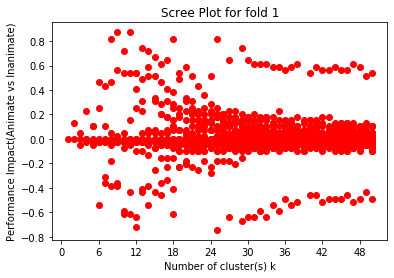

In [15]:
from matplotlib.ticker import MaxNLocator
f = 1
clf_result = result[f]


fig = plt.figure(1)
X = range(1,51,1)
#X = range(2,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance Impact(Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
#plt.savefig('../../results/scree/'+str(method)+'_results_fold_'+str(f)+'.png', format='png', dpi=200)

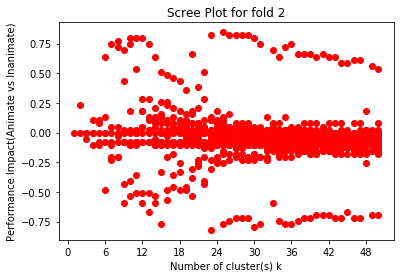

In [16]:
f = 2
clf_result = result[f]


fig = plt.figure(1)
X = range(1,51,1)
#X = range(2,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance Impact(Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
#plt.savefig('../../results/scree/'+str(method)+'_results_fold_'+str(f)+'.png', format='png', dpi=200)

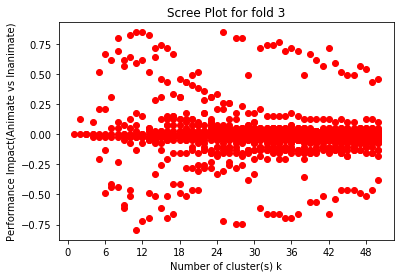

In [17]:
f = 3
clf_result = result[f]


fig = plt.figure(1)
X = range(1,51,1)
#X = range(2,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance Impact(Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
#plt.savefig('../../results/scree/'+str(method)+'_results_fold_'+str(f)+'.png', format='png', dpi=200)

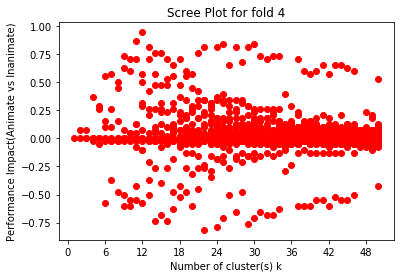

In [18]:
f = 4
clf_result = result[f]


fig = plt.figure(1)
X = range(1,51,1)
#X = range(2,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance Impact(Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
#plt.savefig('../../results/scree/'+str(method)+'_results_fold_'+str(f)+'.png', format='png', dpi=200)

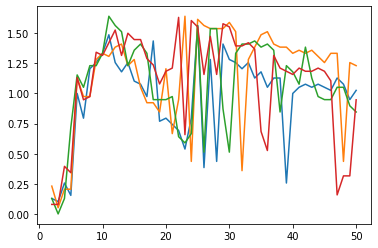

In [20]:
#Find MaxAd', MaxId' and its average
plt.figure()
noc = 4
for i in range(1,noc+1,1):
    X = []
    Y = []
    for j in range(2,51,1):
        X.append(j)
        temp = []
        for key, value in result[i][j].items():
            temp.append(value)
        maxa = max(temp)
        maxi = min(temp)
        avg = float(maxa - maxi)
        Y.append(avg)
    #print X,Y
    plt.plot(X,Y)

1.0163630229419702 24


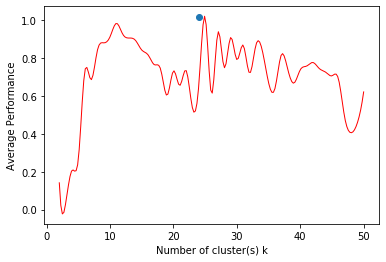

In [24]:
#Smooth average graph
from scipy.interpolate import spline
noc = 4
flag = 0
X = range(2,51,1)
an_fold =[]
ian_fold = []
Y = []
for i in range(1,noc+1,1):
    if i == 2:
        flag = 1
    for j in range(2,51,1):
        temp = []
        for key, value in result[i][j].items():
            temp.append(value)
        maxa = max(temp)
        maxi = min(temp)
        if flag == 0:
            an_fold.append(maxa)
            ian_fold.append(maxi)
        else:
            an_fold[j-2] += maxa
            ian_fold[j-2] = maxi

for j in range(2,51,1):
    maxa = (an_fold[j-2]) / 4.
    maxi = (ian_fold[j-2]) /4.
    diff = maxa - maxi
    Y.append(diff)
    
x_sm = np.array(X)
y_sm = np.array(Y)

x_smooth = np.linspace(x_sm.min(), x_sm.max(), 200)
y_smooth = spline(X, Y, x_smooth)

plt.plot(x_smooth, y_smooth, 'r', linewidth=1)
plt.plot(Y.index(max(Y))+1,max(Y),'o')
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Average Performance")
plt.savefig('../../results/scree/'+str(method)+'_results_fold_avg.png', format='png', dpi=200)
print(max(Y), Y.index(max(Y)) + 1)